In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from yahoofinancials import YahooFinancials
import pandas as pd

sns.set()

## Questions
1. How long to back test for?

In [2]:
dat = yf.Ticker('AAPL')
dat.info

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '(408) 996-1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and p

In [3]:
aapl_df = yf.download(['AAPL'],start='2004-01-01', end='2025-01-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
aapl = yf.Ticker("AAPL")
aapl_options = aapl.options
# aapl_options
aapl_calls = aapl.option_chain(aapl.options[0]).calls
aapl_calls.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL250110C00105000,2024-12-27 16:41:06+00:00,105.0,149.60,138.05,139.45,0.0,0.0,1.0,8.0,3.398439,True,REGULAR,USD
1,AAPL250110C00110000,2024-11-29 17:01:29+00:00,110.0,127.73,0.00,0.00,0.0,0.0,2.0,2.0,0.000010,True,REGULAR,USD
2,AAPL250110C00115000,2025-01-02 17:37:35+00:00,115.0,127.90,128.05,129.45,0.0,0.0,1.0,6.0,3.058596,True,REGULAR,USD
3,AAPL250110C00120000,2024-12-27 16:29:00+00:00,120.0,134.65,123.00,124.50,0.0,0.0,1.0,26.0,2.902346,True,REGULAR,USD
4,AAPL250110C00125000,2024-12-27 17:03:06+00:00,125.0,128.65,118.00,119.50,0.0,0.0,1.0,15.0,2.750003,True,REGULAR,USD


### Start with simple SMA model on AAPL stock

In [5]:
aapl = yf.Ticker('AAPL')
aapl.info
aapl.ticker

'AAPL'

In [6]:
aapl_df = aapl_df #Looks stupid but is preventing downloading as a definition and undoes dropping columns
aapl_df.columns = aapl_df.columns.droplevel(1)
aapl_df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2004-01-02,0.320548,0.327628,0.319041,0.324615,144642400
2004-01-05,0.333954,0.337268,0.322657,0.322657,395018400
2004-01-06,0.332749,0.337720,0.327026,0.335159,509348000
2004-01-07,0.340281,0.343896,0.330339,0.332900,586874400
2004-01-08,0.351880,0.357453,0.341184,0.344047,460303200


<Axes: title={'center': "Apple's 20yr Share Price"}, xlabel='Date'>

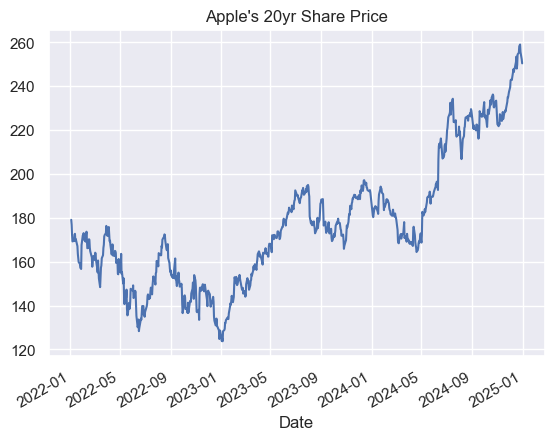

In [7]:
# Print share price
aapl_df['Close'].loc["2022-01-01":"2025-01-01"].plot(title = "Apple's 20yr Share Price")

In [17]:
def sma(asset_df, avg_time):
    return asset_df.rolling(window=avg_time).mean()

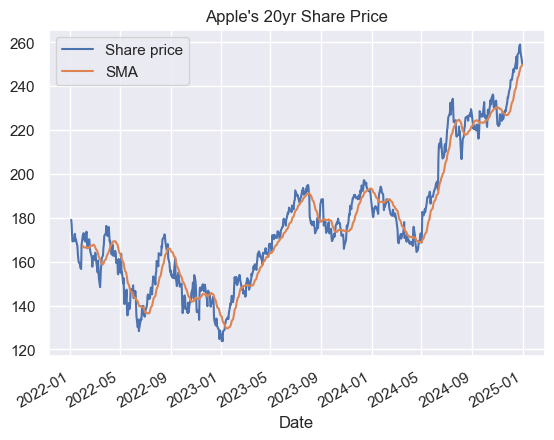

In [18]:
aapl_df['Close'].loc["2022-01-01":"2025-01-01"].plot(title = "Apple's 20yr Share Price", label = 'Share price')
sma(aapl_df['Close'].loc["2022-01-01":"2025-01-01"], 20).plot(label = 'SMA')
plt.legend()

In [19]:
sma(aapl_df['Close'].loc["2022-01-01":"2025-01-01"], 20).head()

Date
2022-01-03   NaN
2022-01-04   NaN
2022-01-05   NaN
2022-01-06   NaN
2022-01-07   NaN
Name: Close, dtype: float64

### Simple strategy for testing
If S(t) is below SMA by 10%, use 10% of initial cash to invest. Need to account for prolonged periods, so strategy ticks once per crossing.

Pseudo-code:

bought = False

for s,t in S(t):
 
    if S(t) < SMA*0.9 and bought = False and cash > 0:
        if invest amount < cash:
            print("Not enough cash")
        else:
            n_shares = invest amount/S(t)
            cash =- invest amount
            bought = True
    
    if S(t) > SMA:
        bought = False

profit = portfolio - initial cash
print(profit)

In [12]:
aapl_df['Close'].head()

Date
2004-01-02    0.320548
2004-01-05    0.333954
2004-01-06    0.332749
2004-01-07    0.340281
2004-01-08    0.351880
Name: Close, dtype: float64

In [25]:
sma(aapl_df['Close'], 20)['2004-01-02']

nan

In [66]:
# Implement strategy

bought = False
cash = 10000
# stock = aapl_20 = aapl_df['Close'] #full 20 yr data set
stock = aapl_df['Close'].loc["2022-01-01":"2025-01-01"] #2 year data set
sma_aapl = sma(stock, 20)
invest = cash*0.1
n_shares = 0
total_invest = 0

for t,s in stock.items():
    if not pd.isna(sma_aapl[t]):
        if s < sma_aapl[t]*0.95 and bought == False:
            if invest <= cash:
                n_shares += invest/s
                # print(f'Buying {invest/s} shares on {t}')
                cash -= invest
                total_invest += invest
                bought = True
            else:
                # print('Ran out of cash')
                break
        if s > sma_aapl[t]:
            bought = False

profit = n_shares*stock.iloc[-1] - total_invest
roi = profit/total_invest*100
print("Profit:", profit, "\nROI:", roi, "\nleftover cash:", cash)


Profit: 6251.801036449922 
ROI: 62.51801036449922 
leftover cash: 0.0
